In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<h3>Generating some data that KMeansClustering can't separate properly</h3>

In [2]:
def return_circle_data(amt,radius_min,radius_max,h_pos=0,y_pos=0):
    points = np.random.random((amt,2))-0.5
    for i in range(len(points)):
        points[i] = points[i]/np.linalg.norm(points[i])
        points[i] = points[i] * (radius_min + (radius_max-radius_min)*np.random.ranf())
    points = points + np.array([h_pos,y_pos])
    return points

def return_arch_data(amt,radius_min,radius_max,h_direction=1,v_direction=1,h_pos=0,y_pos=0):
    points = np.random.random((amt,2))
    points[:,0] = points[:,0]*h_direction
    points[:,1] = points[:,1]*v_direction
    for i in range(len(points)):
        points[i] = points[i]/np.linalg.norm(points[i])
        points[i] = points[i] * (radius_min + (radius_max-radius_min)*np.random.ranf())
    points = points + np.array([h_pos,y_pos])
    return points

In [3]:
huge_circle = return_circle_data(1000,15,16,0,0) 
big_circle = return_circle_data(300,2.5,2.8,0,-9)
small_circle = return_circle_data(300,0.9,1.2,-3,0)
smaller_circle = return_circle_data(200,0,2,-4,10)
arch_one = return_arch_data(200,4,5,1,-1,3,5)
arch_two = return_arch_data(200,4,5,1,1,3,5)
arch_three = return_arch_data(200,4,5,-1,1,5,1)
arch_four = return_arch_data(200,4,5,-1,-1,5,1)

data = np.vstack([huge_circle,big_circle,small_circle,smaller_circle,arch_one,arch_two,arch_three,arch_four])

<h3>The goal is to build a clustering algorithm that can correctly separate these clusters</h3>

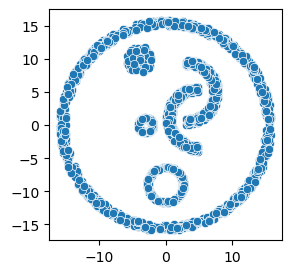

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
sns.scatterplot(x=data[:,0],y = data[:,1])
plt.show()

<h5>This is an implementation of the KDTree that is usefull for storing vectors and then find the closest vectors to a given point </h5>

In [5]:
def calculate_distance(a,b):
    return np.sqrt(sum((a-b)**2))
    
def calculate_axis_distance(a,b,axis):
    return np.abs(a[axis]-b[axis])

def sort_by_column(data,sort_coordinate):
    new_order = data[:,sort_coordinate].argsort()
    data = data[new_order]
    return data

In [6]:
class KDNode:
    def __init__(self,val,axis,index_in_data):
        self.index_in_data = index_in_data
        self.val = val
        self.axis = axis
        self.left = None
        self.right = None

In [7]:
class KDTree:
    def __init__(self):
        self.head = None
    
    def fit(self,data_):
        data = np.hstack([data_,np.arange(len(data_)).reshape(len(data_),1)]).copy()
        self.head = self.__build_tree(data)
    
    def __build_tree(self,data,axis=0):
        if len(data) == 0:
            return None
        
        next_axis = (axis+1)%(data.shape[1]-1) #last column is reserved for index
        
        data = sort_by_column(data,axis)
        median = data[len(data)//2][axis]
        med_id = np.where(data[:,axis]==median)[0][0]
        left_data = data[:med_id]
        right_data = data[med_id+1:]
        
        node_val,node_index = data[med_id][:-1], int(data[med_id][-1])
        node_axis = axis
        node = KDNode(val=node_val,axis=node_axis,index_in_data=node_index)
        
        node.left = self.__build_tree(left_data,next_axis)
        node.right = self.__build_tree(right_data,next_axis)
        
        return node
        
    def find_closer_than(self,val,dist):
        distances = []
        nodes = []
        self.__find_closer_than_go_down(self.head,val,dist,distances,nodes)
        indexes = np.array([node.index_in_data for node in nodes])
        return nodes,distances,indexes
    
    def __find_closer_than_go_down(self,node,val,dist,distances,nodes):
        if node is None:
            return
        curr_dist = calculate_distance(node.val,val)
        if curr_dist<dist:
            distances.append(curr_dist)
            nodes.append(node)
        axis = node.axis
        
        if (val[axis] < node.val[axis]): #Go left
            self.__find_closer_than_go_down(node.left,val,dist,distances,nodes)
            if (calculate_axis_distance(val,node.val,axis) < dist): #Check if need to go right too
                self.__find_closer_than_go_down(node.right,val,dist,distances,nodes)
        
        elif (val[axis] >= node.val[axis]): #Go right
            self.__find_closer_than_go_down(node.right,val,dist,distances,nodes)
            if (calculate_axis_distance(val,node.val,axis) < dist):#Check if need to go left too
                self.__find_closer_than_go_down(node.left,val,dist,distances,nodes)

In [8]:
class DBSCAN:
    def __init__(self,n_neighbours,max_neighbour_distance):
        self.Tree = None
        self.n_neighbours = n_neighbours
        self.max_neighbour_distance = max_neighbour_distance
        self.X = None
        self.labels = None
        self.core_points = None
        self.core_booleans = None
        self.point_neighbours = {}
        
    def calculate_core_points_indexes(self):
        indexes = []
        for i in range(len(self.X)):
            nodes,distances,ids = self.Tree.find_closer_than(self.X[i],self.max_neighbour_distance)
            self.point_neighbours[i] = ids
            if len(nodes) >= self.n_neighbours:
                indexes.append(i)
        return np.array(indexes)

    def expand_core(self,point_index,label):
        to_check = [point_index]
        while len(to_check) > 0:
            curr_point_index = to_check.pop()
            for neighbour in self.point_neighbours[curr_point_index]:
                if self.labels[neighbour] == -1:
                    self.labels[neighbour] = label
                    if self.core_booleans[neighbour] == True:
                        to_check.append(neighbour)
            self.labels[curr_point_index] = label


    def choose_random_unlabeled_core_point(self):
        valid_points = [i for i in self.core_points if self.labels[i] == -1]
        if len(valid_points) == 0:
            return None
        return np.random.choice(valid_points)
        
        
    def fit(self,X):
        self.X = X
        self.labels = np.zeros(len(X))-1 #if label is -1 then it hasnt been chose yet
        self.Tree = KDTree()
        self.Tree.fit(X)
        self.core_points = self.calculate_core_points_indexes()
        self.core_booleans = np.zeros(len(X),dtype = np.bool_)
        self.core_booleans[self.core_points] = True
        curr_label = 0
        point = self.choose_random_unlabeled_core_point()
        while point is not None:
            self.expand_core(point,curr_label)
            point = self.choose_random_unlabeled_core_point()
            curr_label += 1

        cols = 3
        rows = (curr_label + cols - 1) // cols  
        fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
        axs = axs.flatten()
        for label in range(curr_label):
            hues = (self.labels == label)
            sns.scatterplot(x=self.X[:, 0], y=self.X[:, 1], hue=hues, ax=axs[label], legend=False,palette='cool')
            axs[label].set_title("Cluster " + str(label))
            axs[label].set_axis_off()  
        
        for i in range(curr_label, len(axs)):
            axs[i].set_visible(False)

        plt.tight_layout(pad=0.5)
        plt.show()          
        return self.labels.astype(int)

In [9]:
#After some trial and error these parameters are found to work
DBS = DBSCAN(n_neighbours=5,max_neighbour_distance=1)

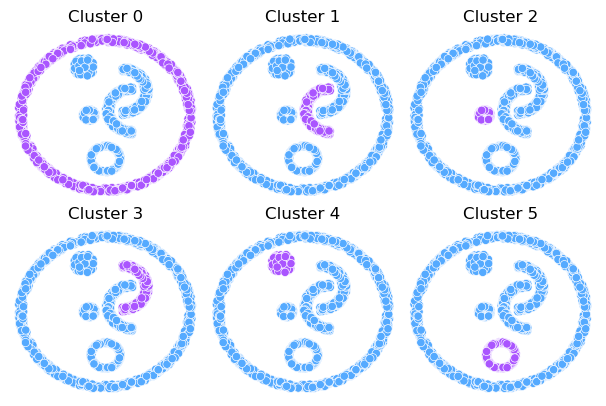

In [10]:
labels = DBS.fit(data)

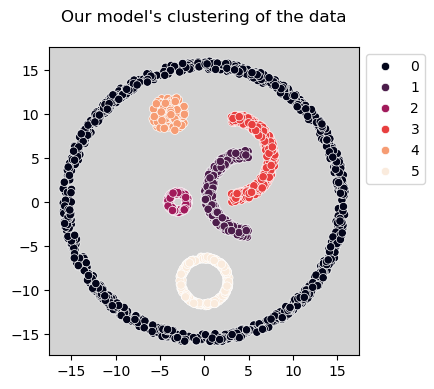

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.set_facecolor('lightgray') 
sns.scatterplot(x=data[:,0],y = data[:,1], hue= labels,palette='rocket')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Our model's clustering of the data\n")
plt.show()

<h3>Good Job !</h3>

<h3>Now we compare to Sklearn</h3>

In [12]:
from sklearn.cluster import DBSCAN as SKDBSCAN

In [13]:
sk_DBS = SKDBSCAN(eps=1,min_samples=5)
sk_labels = sk_DBS.fit_predict(data)

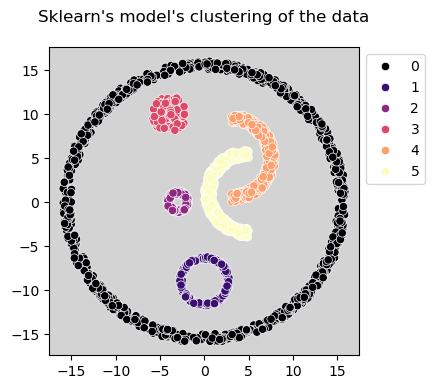

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.set_facecolor('lightgray') 
sns.scatterplot(x=data[:,0],y = data[:,1], hue= sk_labels,palette='magma',)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Sklearn's model's clustering of the data\n")
plt.show()